
import numpy as np
import pandas
import matplotlib as plt

#print ("Hi all")
#weekMax = 51
#NShops = 80
#lastNWeeksDown = 6

def changeConfig(sWeek, sItem, sStore):

    configfilename = "params.txt"
    fconfig = open(configfilename, "r")
    linesList = []
    for l in fconfig:
        toNewConf  = l
        if l.split()[0] == 'sWeek':
            toNewConf = 'sWeek = ' + str(sWeek) + "\n"

        if l.split()[0] == 'sItem':
            toNewConf = 'sItem = ' + str(sItem) + "\n"

        if l.split()[0] == 'sStore':
            toNewConf = 'sStore = ' + str(sStore) + "\n"
        linesList.append(toNewConf)


    fconfig.close()
    fconfig = open(configfilename, "w")
    for line in linesList:
        fconfig.write(line)



def generateSimpleData(delta, alpha, scale, season):

    priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), (1 - delta)*np.ones((NShops,lastNWeeksDown)), 1)
    
    #lastMarkdownArray = (1 - delta/2)*np.ones((NShops,lastNWeeksDown/2))
    #lastMarkdownArray = np.append(lastMarkdownArray, (1 - delta)*np.ones((NShops,lastNWeeksDown/2)), 1)
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), lastMarkdownArray, 1)
    
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), np.random.uniform(1 - delta - 0.1,1 - delta + 0.1 ,(NShops,lastNWeeksDown)), 1)
    
    #effictivityScale = scale*np.arange(1, NShops+1)
    effictivityScale = scale*np.linspace(1, 10, NShops) 

    slsu = np.zeros((NShops, weekMax))
    for weekNo in range(weekMax):
        for ShopNo in range(NShops):
            slsu[ShopNo, weekNo] = np.random.poisson(effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha)))
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return priceMatrix,  slsu


def DataToFile(slsu, price, onHand):
    fLogP = open("RawData/RawDataLogPrice.txt", "w")
    fSlsu = open("RawData/RawDataSLSU.txt", "w")
    fBoh = open("RawData/RawDataBOH.txt", "w")
    
    for shopNo in range(NShops):
        for t in range(weekMax):
            #print np.log(price[shopNo, t]), " "
            fLogP.write(str( -np.log(price[shopNo, t])) + " ")
            fSlsu.write(str(slsu[shopNo, t])+ " ")
            fBoh.write(str(onHand[shopNo, t])+ " ")

if __name__ == "__main__":

    #season = np.cos (np.linspace(0, 2*np.pi, weekMax)) + 2
    #season = np.linspace(1, 0, weekMax) + 2
    season = np.array([1]*weekMax)
    season = season/sum(season)

    price, slsu = generateSimpleData(delta = 0.2, alpha = 1.75, scale = 400, season = season)
    onHand = np.ones((NShops,weekMax) )*100
    #print price, slsu, onHand
    #DataToFile(slsu, price, onHand)
    #changeConfig(sWeek =weekMax , sItem = 1, sStore = NShops)

dics = np.random.randint(0, 12)

price,  slsu, on_hand, rew = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)

res_ser = rew*unit_price
days_left = np.arange(weekMax, 0, -1)  






state_cols = ['d_r_sh', 'days_left']

df = pd.concat([pd.Series(price), 
           pd.Series(season),
           pd.Series(on_hand),
           pd.Series(days_left), 
           pd.Series(slsu), 
           pd.Series(res_ser)], 1)

df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser']
df['d_r_sh'] = df.on_hand / df.slsu


df['action'] = (df.price.shift(-1) - df.price ).fillna(0)

df_shifted = df[state_cols].shift(-1)
df_shifted.columns = [col + '_next' for col in df_shifted.columns]




pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser']]], 1)

In [1]:
%matplotlib inline

In [2]:
def generateSimpleData(delta, alpha, scale, season, init_oh, disc_len, weekMax):

    price = np.append(np.ones( weekMax - disc_len), (1 - delta)*np.ones(disc_len))
    
    slsu = np.zeros(weekMax)
    bst_est = np.zeros(weekMax)
    on_hand = np.zeros(weekMax)
    on_hand[0]=init_oh
    rew = np.zeros(weekMax)
    
    for weekNo in range(weekMax):
        if weekNo:
            on_hand[weekNo] = on_hand[weekNo-1] - slsu[weekNo-1]   
            
        curr_mean =scale*weekMax*season[weekNo]*(price[ weekNo]**(-alpha))
        demand = np.random.poisson(curr_mean)
        slsu[weekNo] = min(demand, on_hand[weekNo])
        rew[weekNo] = slsu[weekNo]*price[weekNo]
        bst_est[weekNo] = curr_mean
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return price,  slsu, on_hand, rew, bst_est

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [4]:
weekMax = 12
init_oh = 800

season = np.array([1]*weekMax)
season = season/sum(season)

In [5]:
res_dict = {}
for dics in tqdm(np.linspace(.0,.7, 40 )):
    tmp_list = []
    for i in range(1000):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = dics, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = 6, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


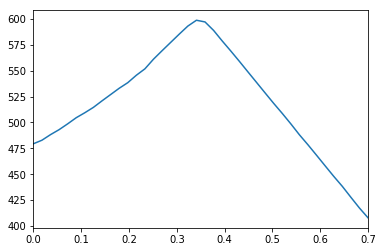

In [6]:
pd.Series(res_dict).plot()

In [7]:
res_dict = {}
for dics in tqdm(range(12)):
    tmp_list = []
    for i in range(100):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)

100%|██████████| 12/12 [00:00<00:00, 89.36it/s]


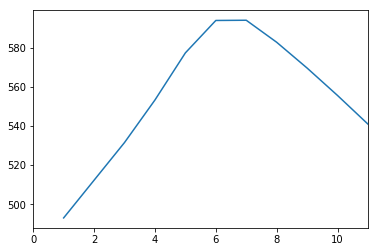

In [8]:
pd.Series(res_dict).rolling(2).mean().plot()

In [9]:
state_cols = ['days_left', 'oh_after']
next_state_cols = [col + '_next' for col in state_cols]

def gen_rl_df(delta, alpha, scale, season, init_oh, disc_len, unit_price =1, weekMax = 12):
    dics = np.random.randint(0, weekMax)
    price,  slsu, on_hand, rew, best_est = generateSimpleData(delta, alpha, scale, \
                                                    season, init_oh, disc_len = dics, weekMax = weekMax)

    res_ser = rew*unit_price
    days_left = np.arange(weekMax, 0, -1)-1


    df = pd.concat([pd.Series(price), 
               pd.Series(season),
               pd.Series(on_hand),
               pd.Series(days_left), 
               pd.Series(slsu), 
               pd.Series(res_ser).shift(-1), 
               pd.Series(best_est)], 1)

    
    df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser', 'bst_est']
    df['d_r_sh'] = df.on_hand / df.slsu
    df['oh_after'] = df.on_hand - df.slsu


    df['action'] = (df.price -1. ).fillna(0)

    df_shifted = df[state_cols].shift(-1)
    df_shifted.columns = next_state_cols

    return pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser', 'slsu', 'bst_est']]], 1)
    


def V(oh_left, reg_sales,disc_sales,delta, days_left  ):
    res_list = [1*min(reg_sales*days_left,oh_left)]
    
    for i in range(days_left):
        reg_price_sales = min(i*reg_sales, oh_left)
        cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
        res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

    return max(res_list)

def Q(oh_left, reg_sales,disc_sales,delta, days_left, action):
    if not days_left:
        return 0
    
    if action >= 0:
        res_list = [1*min(reg_sales*days_left,oh_left)]
        
        for i in range(1, days_left+1):
            reg_price_sales = min(i*reg_sales, oh_left)
            cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
            res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

        return  max(res_list)
    
    return (1- delta)*min(disc_sales*days_left,oh_left)


### Train exact

In [10]:

samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 1000/1000 [00:06<00:00, 165.84it/s]
/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [11]:
from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:

samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
#df['oh_after'] = df.on_hand - df.slsu
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)
df['predicted'] = r.predict(df[['oh_after', 'days_left']].values)

100%|██████████| 100/100 [00:00<00:00, 163.68it/s]
/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Q-learning training

In [14]:
from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
#r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

In [15]:
df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

In [ ]:
for i in tqdm(range(160)):
    if i:
        
        df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
        df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])
        
        df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.
        
        df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
        df['target']   = df.rev_ser + df['V_next']
    else:
        df['target'] = df.rev_ser
        
    r.fit(df[[ 'days_left','oh_after', 'action']].values, df.target.values)


 81%|████████▏ | 130/160 [04:16<00:59,  1.97s/it]

i = 0

print(i)
if i:
        
    df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
    df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])

    df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.

    df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
    df['target']   = df.rev_ser + df['V_next']
else:
    df['target'] = df.rev_ser

r.fit(df[[ 'days_left', 'oh_after','action']].values, df.target.values)
i+=1

In [15]:
!pwd

/Volumes/C/demt_msu_exp/rl_experiments


In [ ]:

df

In [ ]:
samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)


In [ ]:
df['dumm_0'] = 0.
df['dumm_m35'] = -.35
df['Q_keep_pred'] = r.predict(df[['days_left','oh_after', 'dumm_0']].values)
df['Q_disc_pred'] = r.predict(df[['days_left','oh_after', 'dumm_m35']].values)

In [ ]:
df[['days_left', 'on_hand', 'price','rev_ser' ,'Q_keep', 'Q_disc', 'Q_keep_pred', 'Q_disc_pred']]